In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['svg.fonttype'] = 'none'


In [2]:
def read2pd(filename):
    sep = '-'
    if not os.path.exists(filename):
        print(f"{filename} not exist!")
        return None
    with open(filename) as f:
        while True:
            l = f.readline()
            if l == '':
                return None
            l = l.strip()
            if l.startswith(sep):
                head = f.readline().strip().split()
                f.readline()
                break
        content = []
        for _ in range(len(head)):
            content.append([])
        while True:
            l = f.readline().strip()
            if l.startswith(sep):
                break
            l = l.split()
            if len(l) == 15:
                lastterm = l.pop()
                l[-1] = l[-1] + lastterm
            elif len(l) == 13:
                l.append('')
            assert len(l) == len(head)
            for i in range(len(l)):
                content[i].append(l[i])
    pddict = {k: v for k, v in zip(head, content)}
    return pd.DataFrame(pddict)


In [3]:
def read_info(check_dir, list_dir=None):
    if list_dir is None:
        list_dir = check_dir
    all_peps = sorted([f for f in os.listdir(
        list_dir) if f.startswith("add-")])
    print(len(all_peps))
    all_peps = ["-".join(i.split('-')[1:]) for i in all_peps]
    prosit_dict = {"Shared": [], "Gain": [], 'Lost': []}
    prosit_dict_len = {"Shared": [], "Gain": [], 'Lost': []}
    shares = prosit_dict['Shared']
    losses = prosit_dict['Lost']
    gains = prosit_dict['Gain']
    shares_len = prosit_dict_len['Shared']
    losses_len = prosit_dict_len['Lost']
    gains_len = prosit_dict_len['Gain']

    for p in all_peps:
        shared = "share-" + p
        shared = os.path.join(check_dir, shared)
        shared = read2pd(shared)
        shares.append(shared['Score_EL'].astype("float").mean())
        # shares.append(shared['Score_EL'].astype("float").median())
        shares_len.append(shared['Score_EL'])
    for p in all_peps:
        added = "add-" + p
        added = os.path.join(check_dir, added)
        added = read2pd(added)
        gains.append(added['Score_EL'].astype("float").mean())
        # gains.append(added['Score_EL'].astype("float").median())
        gains_len.append(added['Score_EL'])
    for p in all_peps:
        lost = "sub-" + p
        lost = os.path.join(check_dir, lost)
        lost = read2pd(lost)
        if lost is None:
            print(p, "Wrong")
            continue
        losses.append(lost['Score_EL'].astype("float").mean())
        # losses.append(lost['Score_EL'].astype("float").median())
        losses_len.append(lost['Score_EL'])
    return prosit_dict, prosit_dict_len

In [4]:
prosit_sm_check_dir = "/data1/yejb/prosit/figure3/supply_origin/prosit_add/netMHCpan_out"
ft_sm_check_dir = "/data1/yejb/prosit/figure3/supply_origin/finetuned_add/netMHCpan_out"
ft_nonft_check_dir = "/data1/yejb/prosit/figure3/supply_origin/ft_nonft/netMHCpan_out"

prosit_dict, prosit_df = read_info(prosit_sm_check_dir)
ft_dict, ft_df = read_info(ft_sm_check_dir)
ft_noft_dict, ft_noft_df = read_info(ft_nonft_check_dir, list_dir=prosit_sm_check_dir)

92
92
92


In [5]:
def plot_2_boxes(data1, df1, data2, df2, xlabels=None, ymin=-0.1, suppix=''):
    colors = ['darkslateblue', 'green', 'orange']
    medianprops = dict(linestyle='-.', linewidth=2.5, color='black')
    boxprops = dict(linestyle='-.', linewidth=2.5, color='black')
    meanprops = dict(linestyle='--', linewidth=1.5, color='white')
    def dict2data(okdict):
        data = []
        for name in ["Shared", "Gain", "Lost"]:
            data.append(okdict[name])
        return data
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=100)
    prosit_data = dict2data(data1)
    ft_add_data = dict2data(data2)
    labels = ["Shared", "Gain", "Lost"]
    print([len(i) for i in prosit_data])
    print([len(i) for i in ft_add_data])
    bplot1 = ax1.boxplot(prosit_data,
                        notch=True,  # notch shape
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels,
                        medianprops=medianprops,
                        boxprops = boxprops,
                        showmeans=True, meanline=True,
                         meanprops=meanprops)
    bplot2 = ax2.boxplot(ft_add_data,
                        notch=True,  # notch shape
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels,
                        medianprops=medianprops,
                        boxprops=boxprops,
                        showmeans=True, meanline=True,
                        meanprops=meanprops)
    for bplot in (bplot1, bplot2):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            
    for len_pd, ax in zip([df1, df2], [ax1, ax2]):
        ax.yaxis.grid(True)
        ax.set_ylim([ymin,1])
        # ax.text(
        #     0.85, 0.95, f"n=92", fontsize=10)
        # ax.text(
        #     1.85, 0.95, f"n=92", fontsize=10)
        # ax.text(
        #     2.85, 0.95, f"n=92", fontsize=10)
        ax.text(0.85, ymin+0.05, f"n={sum([len(i) for i in len_pd['Shared']])}", fontsize=10)
        ax.text(1.85, ymin+0.05, f"n={sum([len(i) for i in len_pd['Gain']])}", fontsize=10)
        ax.text(
            2.85, ymin+0.05, f"n={sum([len(i) for i in len_pd['Lost']])}", fontsize=10)
    ax1.set_ylabel('NetMHCpan Score', fontsize=15)
    if xlabels is None:
        ax1.set_xlabel("Prosit verus. SM HLA v2", fontsize=12)
        ax2.set_xlabel("Fine-tuned Prosit verus. Prosit", fontsize=12)
    else:
        ax1.set_xlabel(xlabels[0], fontsize=15)
        ax2.set_xlabel(xlabels[1], fontsize=15)
    ax2.set_yticklabels([])
    fig.savefig(f"figs/fig3-allelel-boxplot-netmhcpan{suppix}.svg", dpi=300, bbox_inches="tight")
    plt.tight_layout()

[92, 92, 92]
[92, 92, 92]


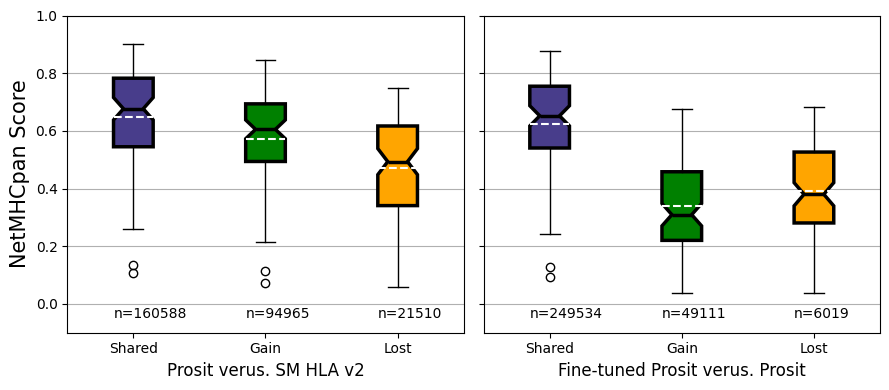

In [6]:
plot_2_boxes(prosit_dict, prosit_df, ft_noft_dict, ft_noft_df, suppix='-FTvP')


[92, 92, 92]
[92, 92, 92]


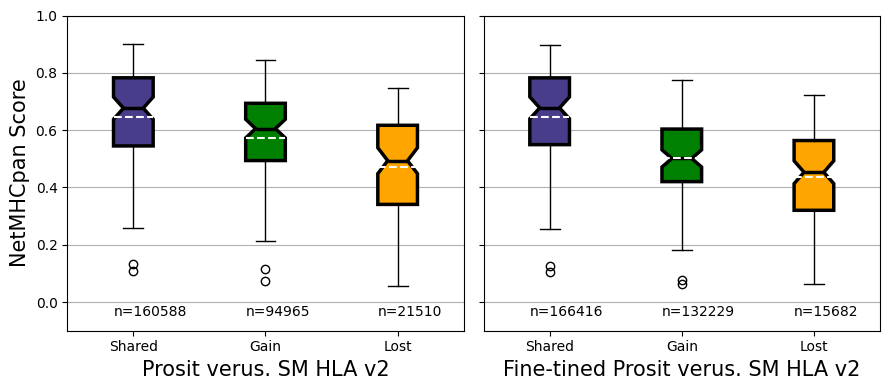

In [7]:
plot_2_boxes(prosit_dict, prosit_df, ft_dict, ft_df, xlabels=[
             'Prosit verus. SM HLA v2', "Fine-tined Prosit verus. SM HLA v2"], suppix="-FTvSM")
